# GAT w/ PyTorch & CORA

In [1]:
import gat
import utils
import torch
import torch.nn.functional as fn

from torch import nn

### Load dataset

In [2]:
cora = utils.load_cora(debug=True)

nodes: torch.Size([2708, 1432])
tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

adjacency: torch.Size([2708, 2708])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

labels: torch.Size([2708])
tensor([1, 1, 4, 4, 4, 4, 6, 4, 5, 4, 0, 3, 3, 1, 2]) ...


In [3]:
print("nodes dataframe:")
cora.df_nodes

nodes dataframe:


,paper_id,word1,word10,word100,word1000,word1001,word1002,word1003,word1004,word1005,...,word990,word991,word992,word993,word994,word995,word996,word997,word998,word999
0,35,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,114,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,117,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1154500,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2704,1154520,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2705,1154524,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2706,1154525,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print("edges dataframe:")
cora.df_edges

edges dataframe:


,citing_paper_id,cited_paper_id
0,35,210872
1,35,210871
2,35,82920
3,40,141342
4,128,114
...,...,...
5424,1154525,8591
5425,1154525,8594
5426,1155073,20857
5427,1155073,6923


In [5]:
print("labels dataframe:")
cora.df_labels

labels dataframe:


,paper_id,class_label
0,35,Genetic_Algorithms
1,40,Genetic_Algorithms
2,114,Reinforcement_Learning
3,117,Reinforcement_Learning
4,128,Reinforcement_Learning
...,...,...
2703,1154500,Case_Based
2704,1154520,Neural_Networks
2705,1154524,Rule_Learning
2706,1154525,Rule_Learning


In [6]:
print("labels map:")
cora.labels_map

labels map:


{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

### Visualize dataset

In [7]:
points = torch.rand(cora.num_nodes, 2)
print(f"points: {points.shape}")
print(points)

points: torch.Size([2708, 2])
tensor([[0.5214, 0.1155],
        [0.4144, 0.9853],
        [0.7358, 0.7048],
        ...,
        [0.4015, 0.3158],
        [0.9869, 0.3220],
        [0.6348, 0.2302]])


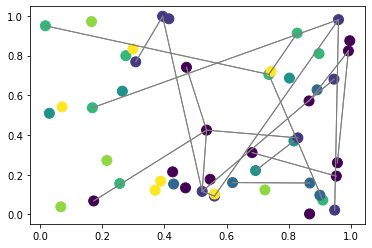

In [8]:
utils.plot_graph(cora.adj[:50, :50], points[:50, :], colors=cora.labels[:50])

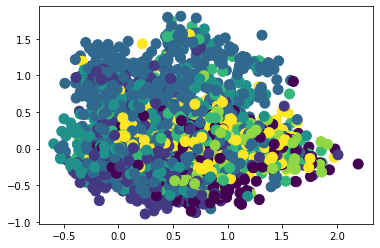

In [9]:
utils.plot_pca(cora.nodes, colors=cora.labels)

### Explore

In [10]:
features = cora.nodes
graph = gat.Graph(cora.edges, features)
print(f"num_nodes: {graph.num_nodes}")
print(f"num_feats: {graph.dim_feats}")

num_nodes: 2708
num_feats: 1432


In [11]:
head_sizes = [8, 1]
head_feats = 8
dim_features = features.shape[1]
dim_embeds = 6

In [12]:
model = gat.GAT(head_sizes, head_feats, dim_features, dim_embeds)
model

GAT(
  (seq): Sequential(
    (0): AttentionLayer(
      (heads): ModuleList(
        (0): AttentionHead(
          (proj_weights): Linear(in_features=1432, out_features=8, bias=False)
          (attn_weights): Linear(in_features=16, out_features=1, bias=False)
        )
        (1): AttentionHead(
          (proj_weights): Linear(in_features=1432, out_features=8, bias=False)
          (attn_weights): Linear(in_features=16, out_features=1, bias=False)
        )
        (2): AttentionHead(
          (proj_weights): Linear(in_features=1432, out_features=8, bias=False)
          (attn_weights): Linear(in_features=16, out_features=1, bias=False)
        )
        (3): AttentionHead(
          (proj_weights): Linear(in_features=1432, out_features=8, bias=False)
          (attn_weights): Linear(in_features=16, out_features=1, bias=False)
        )
        (4): AttentionHead(
          (proj_weights): Linear(in_features=1432, out_features=8, bias=False)
          (attn_weights): Linear(in_fea

In [13]:
embeds = model(graph)
print(f"embeds: {embeds.shape}")
print(embeds)

embeds: torch.Size([2708, 6])
tensor([[ 0.0054, -0.0201,  0.0165,  0.0336, -0.0073,  0.0165],
        [ 0.0069, -0.0058,  0.0385,  0.0070, -0.0238, -0.0064],
        [-0.0022, -0.0128,  0.0134,  0.0137, -0.0091,  0.0162],
        ...,
        [ 0.0044, -0.0222,  0.0168, -0.0187,  0.0222,  0.0467],
        [-0.0127, -0.0068,  0.0099,  0.0100, -0.0095, -0.0042],
        [-0.0048, -0.0208,  0.0177,  0.0324,  0.0264,  0.0110]],
       grad_fn=<MeanBackward1>)


In [14]:
logits = fn.softmax(embeds, dim=1)
y_pred = logits.argmax(dim=1)

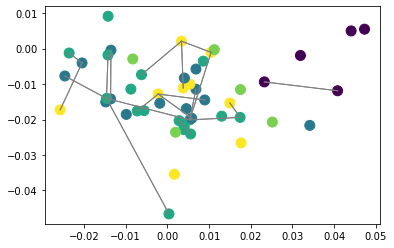

In [15]:
with torch.no_grad():
    utils.plot_graph(cora.adj[:50, :50], embeds[:50, :], colors=y_pred[:50])

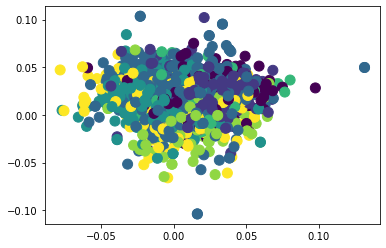

In [16]:
with torch.no_grad():
    utils.plot_pca(embeds, colors=cora.labels)

### Training

In [17]:
learning_rate = 0.01
epochs = 100  # ~10 mins

In [18]:
model = gat.GAT(head_sizes, head_feats, dim_features, cora.num_classes)
xentropy = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
for i in range(epochs):
    print(f"Epoch {i+1:<3} ------")
    gat.train(model, graph, cora.labels, xentropy, optimizer)
    gat.evaluate(model, graph, cora.labels)
    print()
print("done")

Epoch 1   ------
loss: 1.947167
accuracy: 49.5%

Epoch 2   ------
loss: 1.752957
accuracy: 50.1%

Epoch 3   ------
loss: 1.566241
accuracy: 52.6%

Epoch 4   ------
loss: 1.384599
accuracy: 60.2%

Epoch 5   ------
loss: 1.205044
accuracy: 71.2%

Epoch 6   ------
loss: 1.020972
accuracy: 81.2%

Epoch 7   ------
loss: 0.842121
accuracy: 85.9%

Epoch 8   ------
loss: 0.687170
accuracy: 87.6%

Epoch 9   ------
loss: 0.565337
accuracy: 88.3%

Epoch 10  ------
loss: 0.474908
accuracy: 88.8%

Epoch 11  ------
loss: 0.410442
accuracy: 89.4%

Epoch 12  ------
loss: 0.365917
accuracy: 90.0%

Epoch 13  ------
loss: 0.335217
accuracy: 90.2%

Epoch 14  ------
loss: 0.312956
accuracy: 90.7%

Epoch 15  ------
loss: 0.295269
accuracy: 91.1%

Epoch 16  ------
loss: 0.279907
accuracy: 91.4%

Epoch 17  ------
loss: 0.266245
accuracy: 91.7%

Epoch 18  ------
loss: 0.254598
accuracy: 92.1%

Epoch 19  ------
loss: 0.245155
accuracy: 92.2%

Epoch 20  ------
loss: 0.236817
accuracy: 92.3%

Epoch 21  ------
los

### Visualize

In [20]:
embeds = model(graph)
logits = fn.softmax(embeds, dim=1)
y_pred = logits.argmax(dim=1)

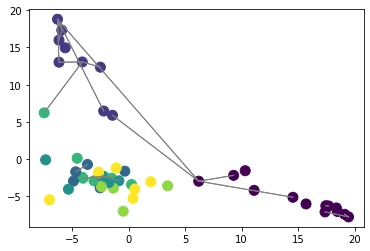

In [21]:
with torch.no_grad():
    utils.plot_graph(cora.adj[:50, :50], embeds[:50, :], colors=y_pred[:50])

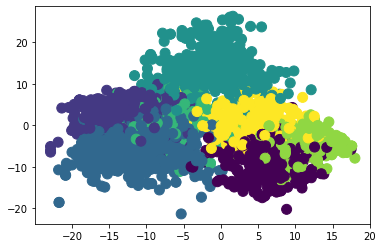

In [22]:
with torch.no_grad():
    utils.plot_pca(embeds, colors=y_pred)